In [1]:
# %cd ".." - install dreye with pip install -e .

In [1]:
from dreye.estimators.dependent_excitation_models import DependentExcitationFit

In [2]:
import dreye
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [3]:
mspectra = dreye.create_measured_spectra_container(
    [340, 360, 400, 450, 505, 565, 620]
)
# mspectra = dreye.create_measured_spectra_container(
#     [340,  450, 565]
# )

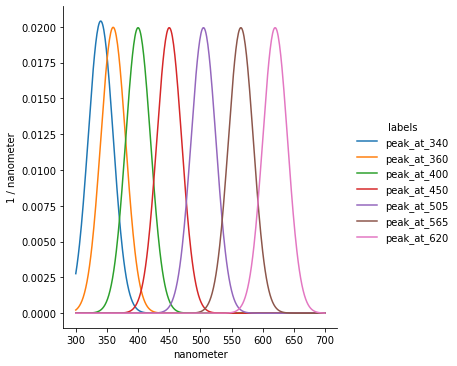

In [4]:
mspectra.normalized_spectra.plot()

In [5]:
mspectra.intensity_bounds

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([100., 100., 100., 100., 100., 100., 100.]))

In [6]:
pr_model = dreye.create_photoreceptor_model(
    [360, 380, 430, 480, 550], 
    photoreceptor_type='log', 
    capture_noise_level=1e-4
)
# pr_model = dreye.create_photoreceptor_model(
#     [360, 430, 550], 
# #     photoreceptor_type='log', 
# #     capture_noise_level=1e-4
# )

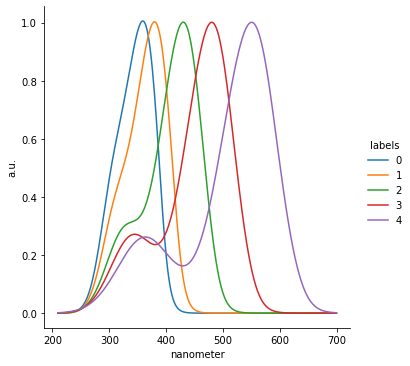

In [7]:
pr_model.sensitivity.plot()

In [8]:
# seed
rng = default_rng(14)

In [9]:
# model with all LEDs available in each subframe

In [20]:
layer_assignments = []
for i in range(8):
    layer_assignments.append(rng.choice(len(mspectra), replace=False, size=3))

In [22]:
bg = 'norm'

In [50]:
resolution = (64, 64)
n_subframes = len(layer_assignments)
bit_depth = 5
n_pixels = resolution[0] * resolution[1]

# random weights for leds
led_weights = rng.random(
    (len(mspectra), n_subframes)
) * 40
led_weights = np.zeros(
    (len(mspectra), n_subframes)
)
for idx, idcs in enumerate(layer_assignments):
    led_weights[idcs, idx] = rng.random(len(idcs)) * rng.integers(70, size=len(idcs))


# normalized capture matrix
A = pr_model.capture(
    mspectra.normalized_spectra, 
    return_units=False, background=bg
)

pixel_strength = rng.random((n_pixels, n_subframes))
pixel_strength = pixel_strength / np.max(pixel_strength)
pixel_strength = (np.ceil(pixel_strength * 2**bit_depth) - 1) / (2**bit_depth - 1)

X = (pixel_strength @ led_weights.T) @ A
X = pr_model.excitefunc(X)

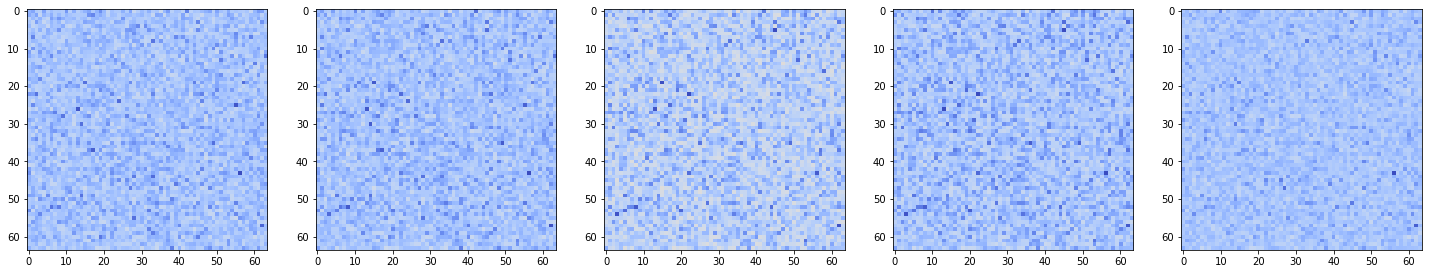

In [51]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(5 * X.shape[1], 5))
for idx, ix in enumerate(X.T):
    axes[idx].imshow(ix.reshape(resolution), vmin=-np.max(np.abs(ix)), vmax=np.max(np.abs(ix)), cmap='coolwarm')

In [55]:
model = DependentExcitationFit(
    photoreceptor_model=pr_model,
    n_epochs=1,
    measured_spectra=mspectra,
    seed=11, 
    independent_layers=n_subframes, 
    bit_depth=bit_depth, 
    epoch_iter=15, 
    n_jobs=None,
    verbose=True, 
    layer_assignments=layer_assignments, 
    exploit=0.3, 
    n_exploit=5, 
    round_during_training=False, 
    normalize_during_training=False,
    sim=False, sample=None, background=bg
#     ignore_bounds=True
)

In [56]:
import time

In [57]:
before = time.time()
model.fit(X)
after = time.time()

epochs: 100%|██████████| 1/1 [01:31<00:00, 91.52s/it]


`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 7.5897e+00, final cost 7.1472e+00, first-order optimality 2.52e-07.


In [58]:
model.score()

0.9924998145847578

In [59]:
model.feature_scores()

array([0.99334866, 0.99017474, 0.99412634, 0.99386884, 0.99098049])

In [60]:
after - before

92.21748471260071